#Motion Deblurring

The project involves deblurring images. The blurred version is obtained through a superposition of slightly translated versions of the same image, following a random trajectory. This kind of blur is supposed to simulate the result of a shot taken with a shaky hand.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We work with images obtained from MNIST.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 1s 0us/step


Below you can find the generator you need to use for your project. Do not modify the number of moves, nor the range of translations. You are free to change the batchsize.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [4]:
my_gen = generator(x_train,5)

In [5]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


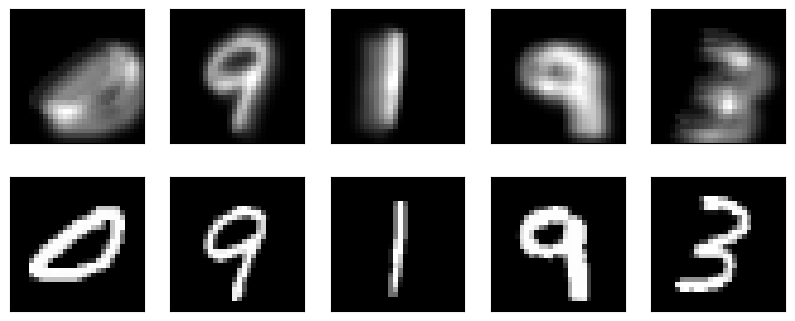

In [6]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Evaluation

Use Mean Squared Error (mse) to evaluate the error between the deblurred image and the ground truth.
Measure mse on 10000 blurred versions of the validation set.

Repeat the prevevious computation 10 times, and gives as a result the **mean
mse over the ten rounds, along with the standard deviation**.

# Split
Divido x_train in x_train_split e x_val_split in modo tale da avere una parte di dataset da utilizzare per la validazione e quindi per regolare i pesi del modello durante l'addestramento. Successivamente utilizzo i dati di test (x_test) solo ed esclusivamente per testare il modello addestrato.

In [7]:
from sklearn.model_selection import train_test_split

# Suddivisione x_train in x_train_split e x_val_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train_split.shape, ' dimensioni train dopo split')
print(x_val_split.shape, ' dimensioni validation dopo split')
print(x_test.shape, ' dimensioni test')

(48000, 28, 28)  dimensioni train dopo split
(12000, 28, 28)  dimensioni validation dopo split
(10000, 28, 28)  dimensioni test


# Modello
Dopo diversi test fatti con altri modelli, il miglior modello (valutato utilizzando MSE) è quello sotto riportato. Ho deciso di utilizzare un autoencoder composto quindi da due parti:
*   Encoder -> per l'encoder ho utilizzato strati convoluzionali Conv2D con dimensione del filtro 3x3 e funzione di attivazione ReLU. A questi strati convoluzionali segue la normalizzazione Batch e Dropout. Lo strato di normalizzazione del batch (BatchNormalization) viene utilizzato per normalizzare gli output degli strati precedenti, aiutando nella stabilità e accelerando l'addestramento. Lo strato di dropout  viene utilizzato per introdurre casualmente la disattivazione di alcuni neuroni durante l'addestramento, contribuendo a prevenire l'overfitting e a garantire un apprendimento più robusto.
L'encoder ha il compito di estrarre delle feature rilevanti dall'input.
*   Decoder -> per il decoder ho utilizzato strati di convoluzione trasposta Conv2DTranspose che cercano di ricostruire l'input originale. L'uso della funzione di attivazione ReLU è mirato a introdurre linearità anche nel processo di decoding. L'ultimo strato invece rappresenta l'output del modello e utilizza la funzione di attivazione "sigmoid" che produce output tra 0 e 1 (valore del pixel in scala di grigi).

Encoder e decoder hanno una struttura simmetrica per quanto riguarda il numero di filtri (Encoder: 16-32-64-128 , Decoder: 128-64-32-16).

Il numero di filtri così come la loro dimensione e la percentuale di dropout è stata scelta in base a diversi test effettuati. Quelli scelti rappresentano la soluzione migliore in relazione al tempo di convergenza del modello e ai risultati ottenuti.



In [8]:
from tensorflow.keras import layers, models, optimizers

def create_model():
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    # Decoder
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same'))

    # Output layer
    model.add(layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'))

    return model


# Train

Per l'addestramento ho utilizzato batch di grandezza 256 per avere un addestramento più veloce. Questo è stato possibile in quanto ho sfruttato anche la GPU (Google Colab Pro). Per evitare overfitting oltre a BatchNormalization e Dropout ho utilizzato anche il modulo EarlyStopping di Keras in modo tale da bloccare l'addestramento se non si verificano miglioramenti nelle performance per 3 epoche di seguito. History viene utilizzata per poter tutti i valori di loss graficati poi nella cella successiva.


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, History

# Creazione modello
model = create_model()

# Compilazione modello
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()


# Addestramento
epochs = 50
batch_size = 256
iterations_per_epoch = len(x_train_split) // batch_size
validation_steps = len(x_val_split) // batch_size

# Generatore per i dati di addestramento
train_generator = generator(x_train_split, batch_size)

# Generatore per i dati di validazione
val_generator = generator(x_val_split, batch_size)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Callback per registrare la history
history_callback = History()

model.fit(
    train_generator,
    steps_per_epoch=iterations_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, history_callback]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                       

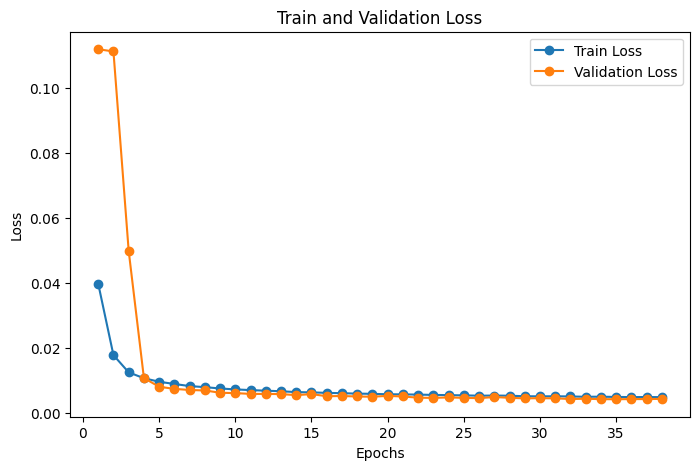

In [10]:
# Estrai i valori di loss dalla history
train_loss = history_callback.history['loss']
val_loss = history_callback.history['val_loss']

# Crea un grafico
plt.figure(figsize=(8, 5))

# Plot della loss di train
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', marker='o')

# Plot della loss di validazione
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Mostra il grafico
plt.show()

# Test

Qui viene eseguito il test del modello precedentemento addestrato. Il test sui 10000 campioni del dataset x_test viene eseguito 10 volte come richiesto dalla traccia del progetto e viene calcolata la deviazione standard tra i 10 risultati ottenuti.

In [11]:
import numpy as np

num_tests = 10
mse_results = []

for _ in range(num_tests):
    # Valutazione del modello sui dati di test
    batch_size = 256
    iterations_per_epoch = len(x_test) // batch_size

    test_generator = generator(x_test, batch_size)

    results = model.evaluate(test_generator, steps=iterations_per_epoch)
    mse_results.append(results)

# Calcolo della media e della deviazione standard dell'MSE
mse_mean = np.mean(mse_results)
mse_std = np.std(mse_results)

print("\nMSE medio su 10 test:", mse_mean)
print("Deviazione standard dell'MSE:", mse_std)

39/39 [==============================] - 5s 132ms/step - loss: 0.0043

MSE medio su 10 test: 0.004272927669808269
Deviazione standard dell'MSE: 7.562907785230952e-05


# Test visivo

Infine viene eseguito un piccolo test "visivo" su 10 campioni per avere un feedback visivo di come il modello riesce a ricostruire una versione non sfocata delle immagini.

Immagine sfocata - Immagine originale
10


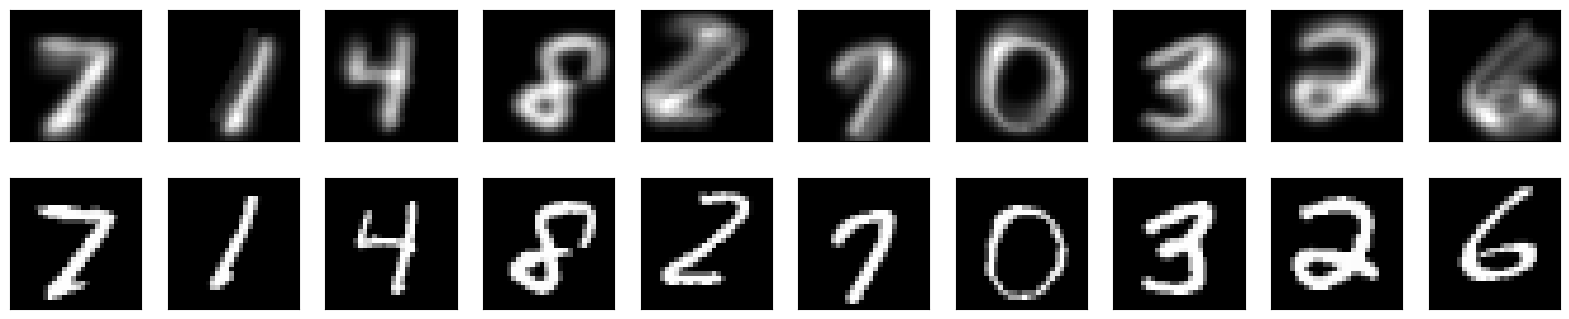

In [18]:
gen_example = generator(x_test, 10)
blurred_example, original_example = next(gen_example)
print('Immagine sfocata - Immagine originale')
plot(blurred_example, original_example)

1/1 [==============================] - 0s 19ms/step
Immagine sfocata - Immagine ricostruita
10


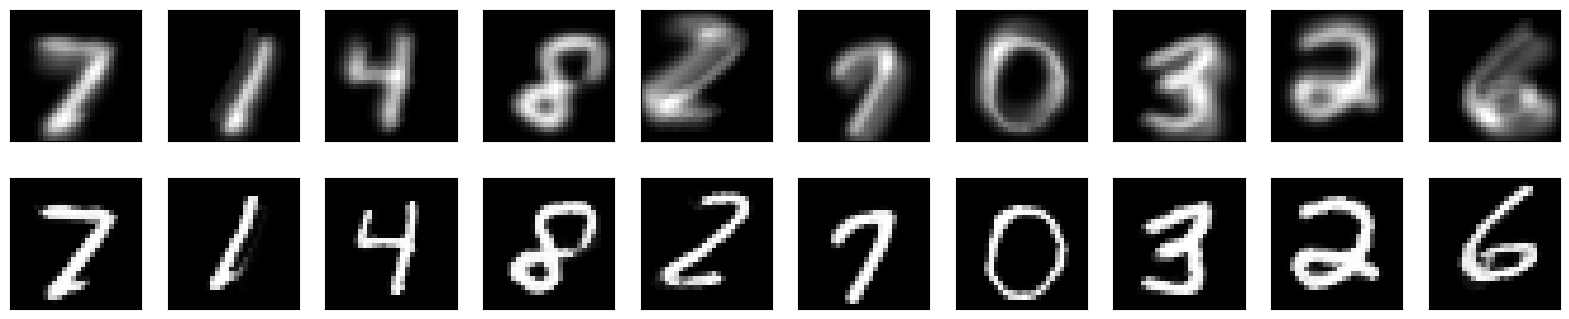

In [19]:
reconstructed_example = model.predict(blurred_example)
print('Immagine sfocata - Immagine ricostruita')
plot(blurred_example, reconstructed_example)
#print(reconstructed_example.shape)